### GAN 논문 링크
<https://arxiv.org/pdf/1406.2661.pdf>

### module/library import

In [1]:
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

### hyper parameter setting

In [20]:
max_epoch = 20
batch_size = 100
lr = 0.0001
z_dim = 64
output_dir = './output/'
if not os.path.exists(output_dir) : os.makedirs(output_dir)
# paramteter 설정 및 output 폴더 없으면 output폴더 만들기

### 데이터 준비

In [21]:
# Image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                        std=(0.5, 0.5, 0.5))])
# data를 torch tensor로 변환하고 normalization 진행

In [22]:
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [25]:
# MNIST dataset
mnist = datasets.MNIST(root='./',
                      train=True,
                      transform=transform,
                      download=True)
# 현재폴더에 raw라는 이름의 폴더 생성 및 MNIST 파일 다운로드 실행

In [27]:
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)
# dataset은 위에서 정의한 MNIST, batch_size는 미리 정의한 100, 데이터 셔플 진행하고, 데이터 끝부분이 잘렸을 경우 데이터셋 채워줌.

- torch.utils.data.DataLoader

dataset (Dataset) – dataset from which to load the data.

batch_size (int, optional) – how many samples per batch to load (default: 1).

shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).

sampler (Sampler, optional) – defines the strategy to draw samples from the dataset. If specified, shuffle must be False.

batch_sampler (Sampler, optional) – like sampler, but returns a batch of indices at a time. Mutually exclusive with batch_size, shuffle, sampler, and drop_last.

num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)

collate_fn (callable, optional) – merges a list of samples to form a mini-batch.

pin_memory (bool, optional) – If True, the data loader will copy tensors into CUDA pinned memory before returning them. If your data elements are a custom type, or your collate_fn returns a batch that is a custom type see the example below.

drop_last (bool, optional) – set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size. If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller. (default: False)

timeout (numeric, optional) – if positive, the timeout value for collecting a batch from workers. Should always be non-negative. (default: 0)

worker_init_fn (callable, optional) – If not None, this will be called on each worker subprocess with the worker id (an int in [0, num_workers - 1]) as input, after seeding and before data loading. (default: None)

<img src="https://github.com/pbj0812/Hello-Generative-Model/raw/4949ad92ab4fc4756930cece247c17f3e01feadb/Day04/GAN/GAN.png">

### Model Definition

In [28]:
# Discriminator
D = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())

- LeakyReLU

LeakyReLU(x)=max(0,x)+negative_slope∗min(0,x)
or

\text{LeakyRELU}(x) = \begin{cases} x, &amp; \text{ if } x \geq 0 \\ \text{negative\_slope} \times x, &amp; \text{ otherwise } \end{cases}
LeakyRELU(x)={ 
x,
negative_slope×x,
​	
  
 if x≥0
 otherwise 
​	

In [29]:
# Generator
G = nn.Sequential(
    nn.Linear(z_dim, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 784),
    nn.Tanh())

In [30]:
if torch.cuda.is_available():
    D.cuda()
    G.cuda()

### LOSS/OPTIMIZER

In [32]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

- nn.BCELoss

Creates a criterion that measures the Binary Cross Entropy between the target and the output:

The unreduced (i.e. with reduction set to 'none') loss can be described as:

\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right],
ℓ(x,y)=L={l 
1
​	
 ,…,l 
N
​	
 } 
⊤
 ,l 
n
​	
 =−w 
n
​	
 [y 
n
​	
 ⋅logx 
n
​	
 +(1−y 
n
​	
 )⋅log(1−x 
n
​	
 )],
where NN is the batch size. If reduction is not 'none' (default 'mean'), then

\ell(x, y) = \begin{cases} \operatorname{mean}(L), &amp; \text{if reduction} = \text{&#x27;mean&#x27;;}\\ \operatorname{sum}(L), &amp; \text{if reduction} = \text{&#x27;sum&#x27;.} \end{cases}
ℓ(x,y)={ 
mean(L),
sum(L),
​	
  
if reduction=’mean’;
if reduction=’sum’.
​	
 
This is used for measuring the error of a reconstruction in for example an auto-encoder. Note that the targets yy should be numbers between 0 and 1.

### ETC function

In [34]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0, 1)

### training

In [35]:
# model restore if any
try:
    G.load_state_dict(torch.load('./generator.pkl'))
    D.load_state_dict(torch.load('./discriminator.pkl'))
    print("---model restored---")
except:
    print("---model not restored---")
    pass

---model restored---


모델 유무 확인

In [37]:
# Start training
total_batch = len(data_loader.dataset)//batch_size
# iteration 지정

In [38]:
total_batch

600

In [61]:
for epoch in range(max_epoch):
    for i, (images, _) in enumerate(data_loader):
        images = images.view(batch_size, -1).cuda()
        # 이미지 로딩
        
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()
        # 실제 레이블은 0으로 채우고, 가짜 레이블은 1로 채움
        
        outputs = D(images)
        # 이미지를 Discriminator에 넣음 (output size 1)
        
        d_loss_real = criterion(outputs, real_labels)
        # discriminator 결과값과 실제 레이블 비교함
        
        real_score = outputs
        
        
        z = torch.randn(batch_size, z_dim).cuda()
        fake_images = G(z).detach()
        # detach() : 이후 연산을 중지한다.
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        # 생성된 그림을 판별한다.
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        # 실제 판별과 가짜 판별을 더하여 loss 값을 구한다.
        
        D.zero_grad()
        # set gradient as 0
        
        d_loss.backward()
        # compute gradient of the loss
        
        d_optimizer.step()
        # apply backpropagation
        
        z = torch.randn(batch_size, z_dim).cuda()
        # 가짜 입력 파일 준비
        
        fake_images = G(z)
        # 가짜 그림 생성
        
        outputs = D(fake_images)
        # 가짜 그림 판별
        
        g_loss = criterion(outputs, real_labels)
        # 가짜 그림 로스 판별
        
        D.zero_grad()
        # set gradient as 0
        
        G.zero_grad()
        # set gradient as 0
        
        g_loss.backward()
        # g compute gradient of the loss
        
        g_optimizer.step()
        # g backpropation
        
        if (i+1) % 300 == 0:
            print('epoch [%d/%d], step[%d/%d], d_loss : %.4f, '
                    'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f'
                    %(epoch, max_epoch, i+1, total_batch, d_loss.item(), g_loss.item(),
                     real_score.data.mean(), fake_score.data.mean()))
                    
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(denorm(images.data), output_dir+'real_iamges.png')
        
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images.data), output_dir+'fake_images-%d.png' %(epoch+1))
    
torch.save(G.state_dict(), './generator.pkl')
torch.save(D.state_dict(), './discriminator.pkl')

epoch [0/20], step[300/600], d_loss : 0.5674, g_loss: 2.9774, D(x): 0.78, D(G(z)): 0.08
epoch [0/20], step[600/600], d_loss : 0.5903, g_loss: 3.2454, D(x): 0.78, D(G(z)): 0.10
epoch [1/20], step[300/600], d_loss : 0.5970, g_loss: 3.1939, D(x): 0.86, D(G(z)): 0.24
epoch [1/20], step[600/600], d_loss : 0.5567, g_loss: 2.8642, D(x): 0.83, D(G(z)): 0.18
epoch [2/20], step[300/600], d_loss : 0.7018, g_loss: 2.2139, D(x): 0.79, D(G(z)): 0.21
epoch [2/20], step[600/600], d_loss : 0.3896, g_loss: 3.0951, D(x): 0.88, D(G(z)): 0.12
epoch [3/20], step[300/600], d_loss : 0.6317, g_loss: 3.5004, D(x): 0.85, D(G(z)): 0.20
epoch [3/20], step[600/600], d_loss : 0.4285, g_loss: 2.6195, D(x): 0.83, D(G(z)): 0.11
epoch [4/20], step[300/600], d_loss : 0.6912, g_loss: 2.9502, D(x): 0.70, D(G(z)): 0.09
epoch [4/20], step[600/600], d_loss : 0.6337, g_loss: 2.8302, D(x): 0.77, D(G(z)): 0.14
epoch [5/20], step[300/600], d_loss : 0.5459, g_loss: 2.7365, D(x): 0.84, D(G(z)): 0.20
epoch [5/20], step[600/600], d_l

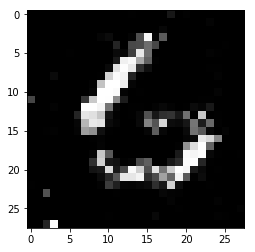

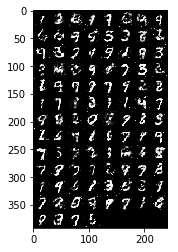

In [65]:
z = torch.randn(batch_size, z_dim).cuda()
fake_images = G(z)
plt.imshow(denorm(fake_images[8].cpu().view(28, 28).data).numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(denorm(fake_images.data.view(batch_size, 1, 28, 28))).cpu().permute(1, 2, 0).numpy())
plt.show()